In [2]:
import numpy as np
from scipy import *
import sys, os
from halotools import sim_manager
import h5py
import WLanalysis

In [3]:
######### parameters

RMpc = 2.0 ## Mpc smoothing
Lbox = 512.0 #Mpc/h
Ngrid = 256.0 ## the grid used for computing power spectrum
Lgrid = Lbox/Ngrid
ibins=arange(Ngrid)
norm_ps = (Lgrid/Ngrid)**3
dataset_name='Subsample'

In [4]:
######### subsampled file
subsample_fn = '/Users/jia/neutrino-batch/sample_maps/mnv0.10000_om0.30000_As2.1000/snapshot_066_idmod_101_0.hdf5'
f=h5py.File(subsample_fn,'r')
dataset = f[dataset_name]
particle_pos = dataset['Position']/1e3

In [5]:
############ my previous unsmoothed code
nudir='/Users/jia/Documents/weaklensing/nubias/'
k512,pk512=load(nudir+'kpk_512grid.npy')
k128,pk128=load(nudir+'kpk_128grid.npy')
k256,pk256=load(nudir+'kpk_256grid.npy')

########### full gadget output
kful,pkful=genfromtxt('/Users/jia/neutrino-batch/matterpower/mnv0.10000_om0.30000_As2.1000/powerspec_tot_066.txt').T
knu,pknu=genfromtxt('/Users/jia/neutrino-batch/matterpower/mnv0.10000_om0.30000_As2.1000/powerspec_nu_066.txt').T
fnu=0.1/93.14/0.3/.7**2
pkdm=(sqrt(pkful)-fnu*sqrt(pknu))**2/(1-fnu)**2

########### Marcel's code
ks, pks, Ns = genfromtxt(nudir+'Pk_snapshot_066_idmod_101_0.hdf5_Ng512.txt').T

In [6]:
def gridding (pos):
    grid = histogramdd(pos/Lbox*Ngrid,bins=[ibins,ibins,ibins])[0]
    grid = grid/mean(grid) - 1.0
    return grid

def ps (pos):
    grid = gridding(pos)
    k, ps3d = WLanalysis.PowerSpectrum3D(grid)
    return 2*pi*k/Lbox, ps3d*norm_ps

In [7]:
#ktest, pstest = ps(particle_pos)

In [8]:
igrid = gridding(particle_pos)

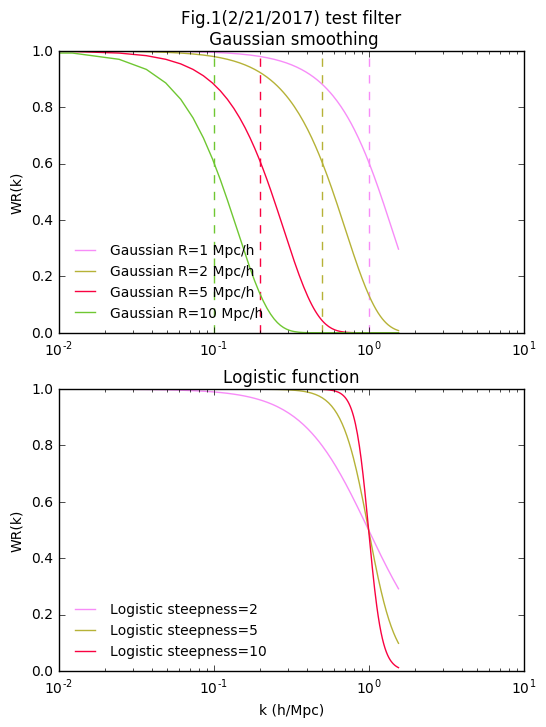

In [68]:
#Rpix=RMpc*Ngrid/Lbox
f=figure(figsize=(6,8))
ax=f.add_subplot(211)
ax2=f.add_subplot(212)
    
seed(4)
for iRMpc in [1,2,5,10]: 
    ik = 1.0/iRMpc
    icolor=rand(3)
    ifreq = arange(Ngrid/2)*2*pi/Lbox
    WR = exp(-(ifreq*iRMpc)**2/2.0)
    ax.plot(ifreq,WR,color=icolor,label='Gaussian R=%i Mpc/h'%(iRMpc))
    ax.plot([ik,ik],[0,1],'--',color=icolor)
seed(4)
for isteep in (2,5,10):
    icolor=rand(3)
    WR = 1-1.0/(1.0+exp(-isteep*log(ifreq)))
    ax2.plot(ifreq,WR,color=icolor,label='Logistic steepness=%i'%(isteep))
    #ax2.plot([0.5,0.5],[0,1],'--',color=icolor)
    
#ax.set_xlabel('k (h/Mpc)')
ax.legend(loc=0,fontsize=10,frameon=0)
ax.set_ylabel('WR(k)')
ax.set_xscale('log')
ax.set_title('Fig.1(2/21/2017) test filter\n Gaussian smoothing')
ax2.set_xlabel('k (h/Mpc)')
ax2.legend(loc=0,fontsize=10,frameon=0)
ax2.set_ylabel('WR(k)')
ax2.set_xscale('log')
ax2.set_title('Logistic function')
show()

In [10]:
def smoothing (grid, isteep=10.0, kcut=1.0, RMpc=0.0):
    kmax=2.0*pi/Lbox*Ngrid/2.0
    grid_fft = fftshift(fftpack.fftn(grid))
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
    if grid.shape[0]%2 == 0:
        center+=0.5
    #d = Lbox/Ngrid
    freq_cube = sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    freq_cube *= 2*pi/Lbox ### since k = k_machine /(d*N), N=Ngrid d=Lbox/Ngrid, d*N=Lbox
    if RMpc:
        WR = exp(-(freq_cube*RMpc)**2/2.0)
        #WR = exp(-(2*pi*freq_cube*Rpix)**2/2.0)
    else:
        WR = 1-1.0/(1.0+exp(-isteep*log(freq_cube/kcut)))
    WR[freq_cube>=kmax]=0.0 ### cut off at kmax
    grid_fft *= WR
    return ifftn(ifftshift(grid_fft*WR))

isteep=10.0
WRL = lambda freq_cube, kcut: 1-1.0/(1.0+exp(-isteep*log(freq_cube/kcut)))
WRG = lambda freq_cube, RMpc: exp(-(freq_cube*RMpc)**2/2.0)

In [11]:
igrid_smooth01 = smoothing(igrid, kcut=0.1)
igrid_smooth1 = smoothing(igrid, kcut=1.0)
igrid_testfft = ifftn(fftn(igrid))

In [12]:
igrid_smoothR10 = smoothing(igrid, RMpc=10.0)

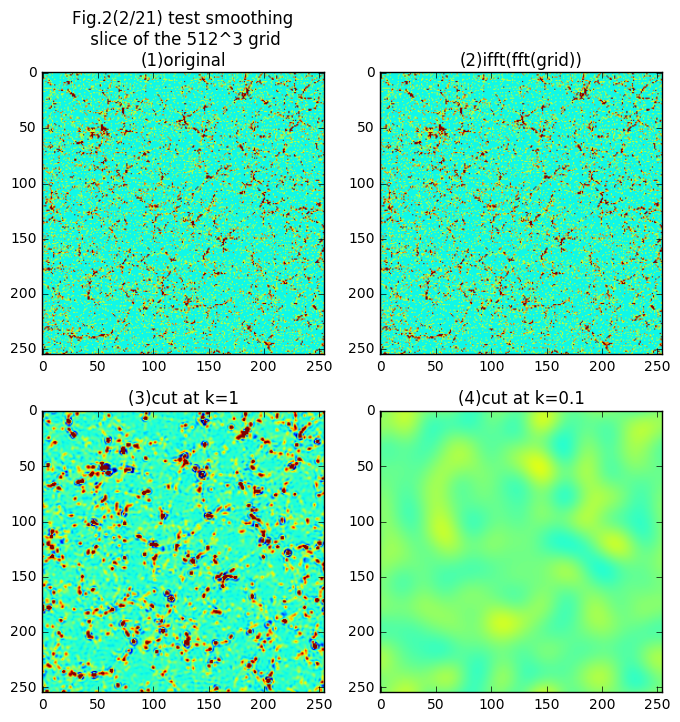

In [13]:
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
istd=std(igrid[100])

cb1=ax1.imshow(igrid[100],vmax=istd, vmin=-istd)
cb2=ax2.imshow(real(igrid_testfft[100]),vmax=istd, vmin=-istd)
cb3=ax3.imshow(real(igrid_smooth1[100]),vmax=istd, vmin=-istd)
cb4=ax4.imshow(real(igrid_smooth01[100]),vmax=istd, vmin=-istd)
ax1.set_title('Fig.2(2/21) test smoothing\n slice of the 512^3 grid\n(1)original')
ax2.set_title('(2)ifft(fft(grid))')
ax3.set_title('(3)cut at k=1')
ax4.set_title('(4)cut at k=0.1')
show()

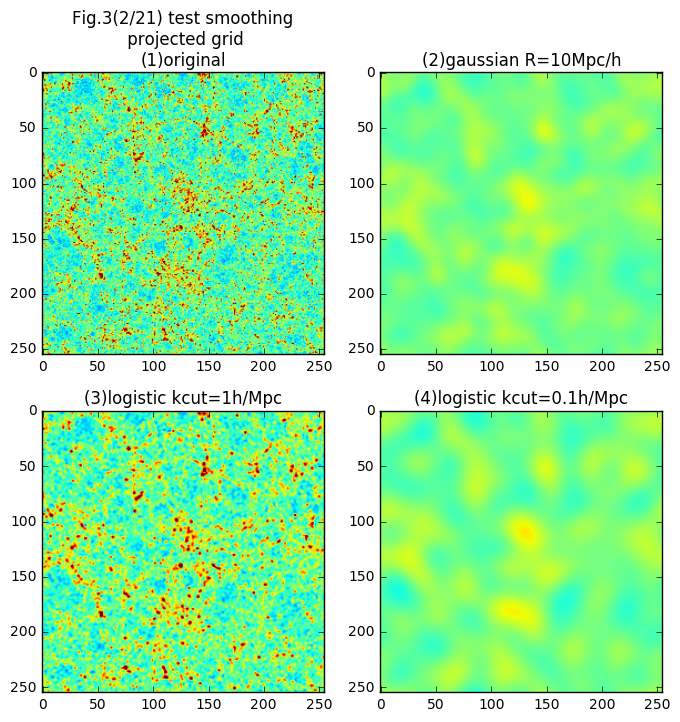

In [14]:
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
istd=std(mean(igrid,axis=0))*3

cb1=ax1.imshow(mean(igrid,axis=0),vmax=istd, vmin=-istd)
cb2=ax2.imshow(mean(real(igrid_smoothR10),axis=0),vmax=istd, vmin=-istd)
cb3=ax3.imshow(mean(real(igrid_smooth1),axis=0),vmax=istd, vmin=-istd)
cb4=ax4.imshow(mean(real(igrid_smooth01),axis=0),vmax=istd, vmin=-istd)

ax1.set_title('Fig.3(2/21) test smoothing\n projected grid\n(1)original')
ax2.set_title('(2)gaussian R=10Mpc/h')
ax3.set_title('(3)logistic kcut=1h/Mpc')
ax4.set_title('(4)logistic kcut=0.1h/Mpc')
show()

In [15]:
ps_smooth1 = WLanalysis.PowerSpectrum3D(real(igrid_smooth1))
ps_smooth01 = WLanalysis.PowerSpectrum3D(real(igrid_smooth01))

/Users/jia/Documents/code/WLanalysis/WLanalysis.py:570: RuntimeWarning: invalid value encountered in divide
  radial_prof = tbin/hist_ind[1:]


In [16]:
pss1 = ps_smooth1[1] *norm_ps
pss01 = ps_smooth01[1] *norm_ps

In [17]:
ps_smoothR10 = WLanalysis.PowerSpectrum3D(real(igrid_smoothR10))
pssR10 = ps_smoothR10[1] *norm_ps

/Users/jia/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


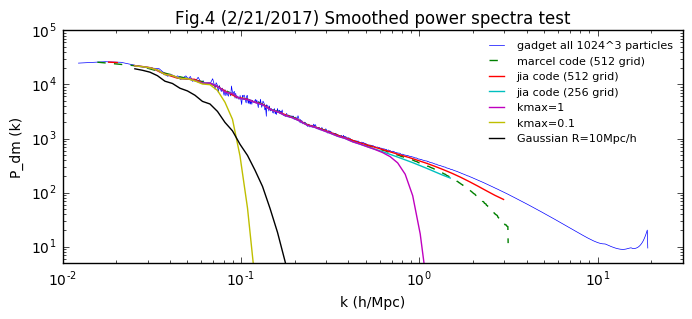

In [18]:
figure(figsize=(8,3))
loglog(kful*1e3,pkdm/1e9,'-',lw=0.5, label='gadget all 1024^3 particles')
loglog(ks,pks,'--', label='marcel code (512 grid)')
loglog(k512,pk512, label='jia code (512 grid)')
loglog(k256,pk256, label='jia code (256 grid)')
loglog(k256,pss1, label='kmax=1')
loglog(k256,pss01, label='kmax=0.1')
loglog(k256,pssR10, label='Gaussian R=10Mpc/h')
#loglog(k128,pk128, label='jia code (128 grid)')
#loglog(ktest,pstest, label='jia code (256 grid test)')
legend(fontsize=8,frameon=0)
title('Fig.4 (2/21/2017) Smoothed power spectra test')
xlim(1e-2,30)
ylim(5,1e5)
xlabel('k (h/Mpc)')
ylabel('P_dm (k)')
show()

In [19]:
######### test squeezed by spectrum, smoothed vs unsmoothed
ik, ibs = WLanalysis.CrossPowerSpectrum3D(igrid**2,igrid)
ik, ibss = WLanalysis.CrossPowerSpectrum3D(real(igrid_smooth01)**2,real(igrid_smooth01))
ik, ibss1 = WLanalysis.CrossPowerSpectrum3D(real(igrid_smooth1)**2,real(igrid_smooth1))
ik, ibsR10 = WLanalysis.CrossPowerSpectrum3D(real(igrid_smoothR10)**2,real(igrid_smoothR10))

/Users/jia/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2115: ComplexWarning: Casting complex values to real discards the imaginary part
  return cumsum(axis, dtype, out)


In [20]:
igrid_smoothR1 = smoothing(igrid, RMpc=1.0)
ps_smoothR1 = WLanalysis.PowerSpectrum3D(real(igrid_smoothR1))
pssR1 = ps_smoothR1[1] *norm_ps
ik, ibsR1 = WLanalysis.CrossPowerSpectrum3D(real(igrid_smoothR1)**2,real(igrid_smoothR1))

/Users/jia/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


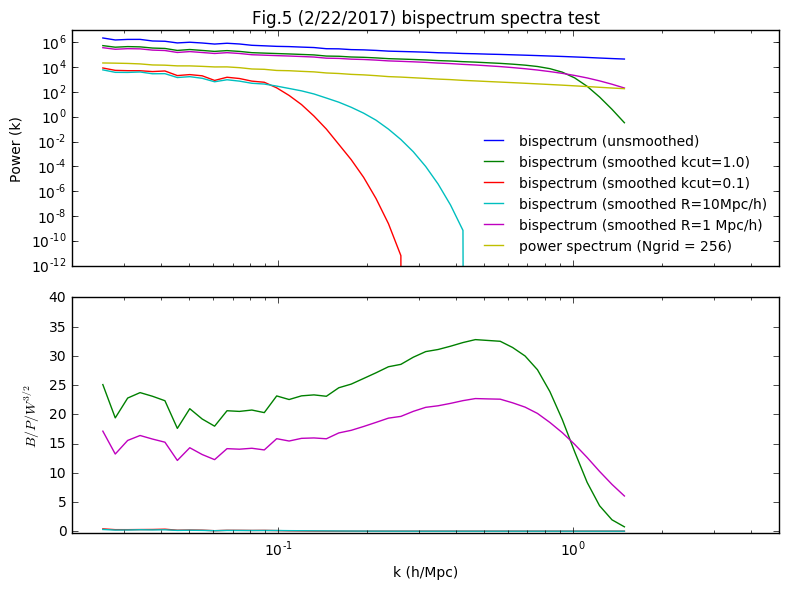

In [21]:
f, (ax1, ax2) = subplots(2,1,figsize=(8,6),sharex=True)
ax1.plot(k256,ibs*norm_ps, label='bispectrum (unsmoothed)')
ax1.plot(k256,ibss1*norm_ps, label='bispectrum (smoothed kcut=1.0)')
ax1.plot(k256,ibss*norm_ps, label='bispectrum (smoothed kcut=0.1)')
ax1.plot(k256,ibsR10*norm_ps, label='bispectrum (smoothed R=10Mpc/h)')
ax1.plot(k256,ibsR1*norm_ps, label='bispectrum (smoothed R=1 Mpc/h)')
ax1.plot(k256,pk256, label='power spectrum (Ngrid = 256)')

ax1.legend(fontsize=10,frameon=0,loc=0)
ax1.set_title('Fig.5 (2/22/2017) bispectrum spectra test')
ax1.set_xlim(2e-2,5)
#ylim(5,1e5)
ax2.set_xlabel('k (h/Mpc)')
ax1.set_ylabel('Power (k)')
ax1.set_xscale('log')
ax1.set_yscale('log')


#WRL = lambda freq_cube, kcut: 1-1.0/(1.0+exp(-isteep*log(freq_cube/kcut)))
#WRG = lambda freq_cube, RMpc: exp(-(freq_cube*RMpc)**2/2.0)
ax2.plot(k256,ibs*norm_ps/pk256, label='bispectrum (unsmoothed)')
ax2.plot(k256,ibss1*norm_ps/pk256/WRL(k256,1.0)**1.5, label='bispectrum (smoothed kcut=1.0)')
ax2.plot(k256,ibss*norm_ps/pk256/WRL(k256,0.1)**1.5, label='bispectrum (smoothed kcut=0.1)')
ax2.plot(k256,ibsR10*norm_ps/pk256/WRG(k256,10.0)**1.5, label='bispectrum (smoothed R=10Mpc/h)')
ax2.plot(k256,ibsR1*norm_ps/pk256/WRG(k256,1.0)**1.5, label='bispectrum (smoothed R=1 Mpc/h)')
ax2.set_xscale('log')
ax2.set_ylabel(r'$B/P/W^{3/2}$')
ax2.set_ylim(-0.3, 40)
plt.tight_layout()
show()

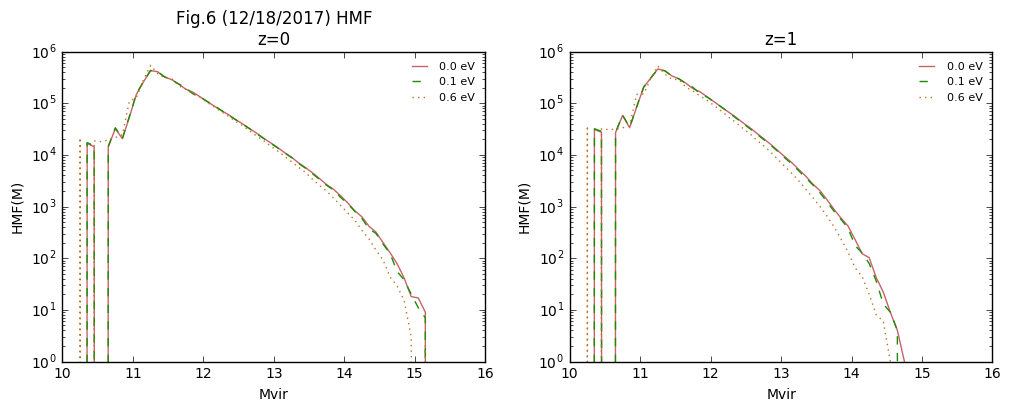

In [22]:
########### cut halo mass function
hmf00_z1 = load('hmf/hmf_mnv0.00000_om0.30000_As2.1000_048.npy')
hmf00_z0 = load('hmf/hmf_mnv0.00000_om0.30000_As2.1000_066.npy')

hmf01_z1 = load('hmf/hmf_mnv0.10000_om0.30000_As2.1000_048.npy')
hmf01_z0 = load('hmf/hmf_mnv0.10000_om0.30000_As2.1000_066.npy')

hmf06_z1 = load('hmf/hmf_mnv0.60000_om0.30000_As2.1000_048.npy')
hmf06_z0 = load('hmf/hmf_mnv0.60000_om0.30000_As2.1000_066.npy')

hist_bins=arange(10, 15.5, 0.1)
hist_center=hist_bins[:-1]+0.05

iseed=10024
f=figure(figsize=(12,4))
ax1=f.add_subplot(121)
ax2=f.add_subplot(122)

seed(iseed)
ax1.plot(hist_center,hmf00_z0,'-',color=rand(3),label='0.0 eV')
ax1.plot(hist_center,hmf01_z0,'--',color=rand(3),label='0.1 eV')
ax1.plot(hist_center,hmf06_z0,':',color=rand(3),label='0.6 eV')
ax1.legend(fontsize=8,frameon=0,loc=0)
ax1.set_title('''Fig.6 (12/18/2017) HMF
z=0''')
ax1.set_ylabel('HMF(M)')
ax1.set_xlabel('Mvir')
ax1.set_yscale('log')

seed(iseed)
ax2.plot(hist_center,hmf00_z1,'-',color=rand(3),label='0.0 eV')
ax2.plot(hist_center,hmf01_z1,'--',color=rand(3),label='0.1 eV')
ax2.plot(hist_center,hmf06_z1,':',color=rand(3),label='0.6 eV')
ax2.legend(fontsize=8,frameon=0,loc=0)
ax2.set_title('z=1')
ax2.set_ylabel('HMF(M)')
ax2.set_xlabel('Mvir')
ax2.set_yscale('log')
show()

In [23]:
#hist_bins=arange(10, 15.5, 0.1)
#hist_center=hist_bins[:-1]+0.05
#hmf00_z0
bin_edges = [12, 12.5, 13, 16]
for ii in arange(len(bin_edges)-1):
    print 'z=0',bin_edges[ii:ii+2],sum(hmf00_z0[(hist_bins[:-1]>=bin_edges[ii])&(hist_bins[:-1]<bin_edges[ii+1])])
for ii in arange(len(bin_edges)-1):
    print 'z=1',bin_edges[ii:ii+2],sum(hmf00_z1[(hist_bins[:-1]>=bin_edges[ii])&(hist_bins[:-1]<bin_edges[ii+1])])

z=0 [12, 12.5] 310679
z=0 [12.5, 13] 111619
z=0 [13, 16] 50914
z=1 [12, 12.5] 283146
z=1 [12.5, 13] 84550
z=1 [13, 16] 24711


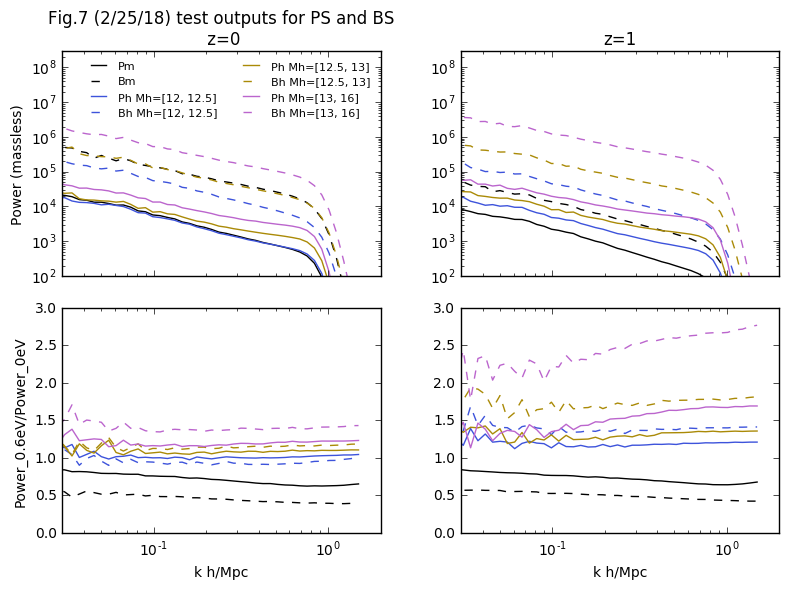

In [84]:
######### check sample file from mass production
### z=1 is snapshot48

test_data = load('Ph2h/Ph2h_mnv0.00000_om0.30000_As2.1000_066.npy')
test_data06 = load('Ph2h/Ph2h_mnv0.60000_om0.30000_As2.1000_066.npy')
test_data_z1 = load('Ph2h/Ph2h_mnv0.00000_om0.30000_As2.1000_048.npy')
test_data06_z1 = load('Ph2h/Ph2h_mnv0.60000_om0.30000_As2.1000_048.npy')

k = test_data[0]

f, ( (ax,ax3),(ax2, ax4)) = subplots(2,2,figsize=(8,6),sharex=True)
iii=-1
seed(43)
labels=['Pm','Bm', 'Ph Mh=[12, 12.5]', 'Bh Mh=[12, 12.5]', 'Ph Mh=[12.5, 13]', 'Bh Mh=[12.5, 13]', 'Ph Mh=[13, 16]', 'Bh Mh=[13, 16]']
for idata in test_data[1:]:
    iii+=1
    iline='--'
    idata_z1 = test_data_z1[iii+1]
    idata06 = test_data06[iii+1]
    idata06_z1 = test_data06_z1[iii+1]
    ilw=1
    if not iii%2:
        iline='-'
        icolor=rand(3)
    if iii<2:
        #ilw=3
        icolor='k'
    ax.plot(k, idata, iline, color=icolor, label = labels[iii],lw=ilw)
    ax2.plot(k, idata06/idata, iline, color=icolor,lw=ilw)
    ax3.plot(k, idata_z1, iline, color=icolor, label = labels[iii],lw=ilw)
    ax4.plot(k, idata06_z1/idata_z1, iline, color=icolor,lw=ilw)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax3.set_yscale('log')
ax2.set_xlabel('k h/Mpc')
ax4.set_xlabel('k h/Mpc')
ax.set_ylabel('Power (massless)')
ax2.set_ylabel('Power_0.6eV/Power_0eV')
ax.set_ylim(1e2, 3e8)
ax3.set_ylim(1e2, 3e8)
ax.set_xlim(3e-2, 2)
ax2.set_ylim(0,3)
ax4.set_ylim(0,3)
ax.legend(ncol=2,frameon=0,fontsize=8,loc=0)
ax.set_title('Fig.7 (2/25/18) test outputs for PS and BS\n z=0')
ax3.set_title('z=1')
plt.tight_layout()
show()

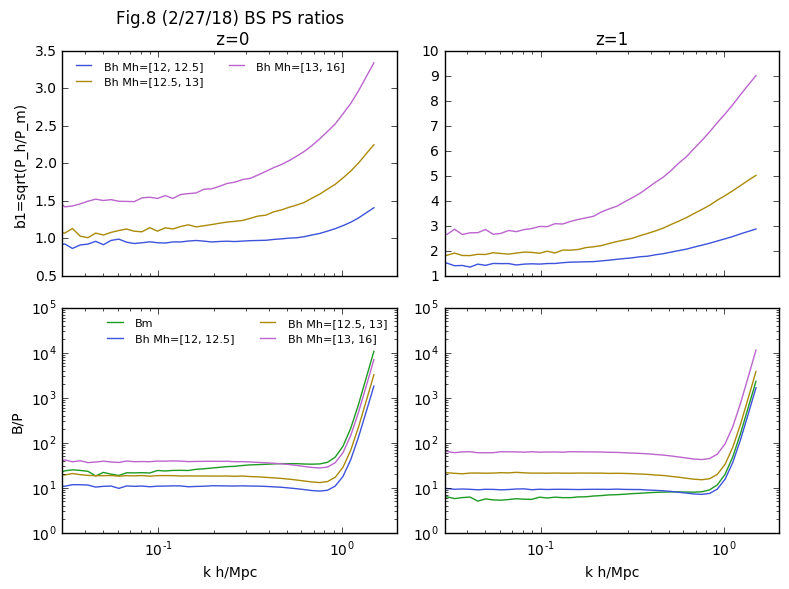

In [104]:
######### check sample file from mass production
### z=1 is snapshot48

test_data = load('Ph2h/Ph2h_mnv0.00000_om0.30000_As2.1000_066.npy')
test_data06 = load('Ph2h/Ph2h_mnv0.60000_om0.30000_As2.1000_066.npy')
test_data_z1 = load('Ph2h/Ph2h_mnv0.00000_om0.30000_As2.1000_048.npy')
test_data06_z1 = load('Ph2h/Ph2h_mnv0.60000_om0.30000_As2.1000_048.npy')

k = test_data[0]

f, ( (ax,ax3),(ax2, ax4)) = subplots(2,2,figsize=(8,6),sharex=True)

seed(43)
labels=['Pm','Bm', 'Ph Mh=[12, 12.5]', 'Bh Mh=[12, 12.5]', 'Ph Mh=[12.5, 13]', 'Bh Mh=[12.5, 13]', 'Ph Mh=[13, 16]', 'Bh Mh=[13, 16]']
for iii in [2,4,6,8]:
    test_data_z1[iii]
    icolor=rand(3)
    if iii>3: ## biases
        ax.plot(k, sqrt(test_data[iii-1]/test_data[1]), color=icolor, label = labels[iii-1], lw=ilw)
        ax3.plot(k, sqrt(test_data_z1[iii-1]/test_data_z1[1]), color=icolor, label = labels[iii-1], lw=ilw)
    
    ax2.plot(k, test_data[iii]/test_data[iii-1], '-', color=icolor,lw=ilw,label = labels[iii-1])
    ax4.plot(k, test_data_z1[iii]/test_data_z1[iii-1], '-', color=icolor,lw=ilw,label = labels[iii-1])
    
ax.set_xscale('log')
#ax.set_yscale('log')
#ax3.set_yscale('log')
ax2.set_yscale('log')
ax4.set_yscale('log')
ax2.set_xlabel('k h/Mpc')
ax4.set_xlabel('k h/Mpc')
ax.set_ylabel('b1=sqrt(P_h/P_m)')
ax2.set_ylabel('B/P')
#ax.set_ylim(1e2, 3e8)
#ax3.set_ylim(1e2, 3e8)
ax.set_xlim(3e-2, 2)
#ax2.set_ylim(0,3)
#ax4.set_ylim(0,3)
ax.legend(ncol=2,frameon=0,fontsize=8,loc=0)
ax2.legend(ncol=2,frameon=0,fontsize=8,loc=0)

ax.set_title('Fig.8 (2/27/18) BS PS ratios\n z=0')
ax3.set_title('z=1')
plt.tight_layout()
show()

In [165]:
######## compute b1 for all models, using first 14 non-zero bin
cosmo_params = genfromtxt('cosmological_parameters.txt',usecols=[1,2,3,4],skip_header=1)
nsnaps_arr = loadtxt('nsnap_jia.txt')
cosmo_params = delete(cosmo_params,39,axis=0)
nsnaps_arr = delete(nsnaps_arr,39)

idx_b1 = [ 0,  3,  5,  7,  8,  9, 10, 11, 12, 13] ## k<0.05 and Nmode>0
def b1gen (iii):
    mnv,om,As,si8=cosmo_params[iii]
    fn = 'Ph2h/Ph2h_mnv%.5f_om%.5f_As%.4f_%03d.npy'%(mnv,om,As,nsnaps_arr[iii]-1)
    fnPhm = 'Phm/Phm_mnv%.5f_om%.5f_As%.4f_%03d.npy'%(mnv,om,As,nsnaps_arr[iii]-1)
    idata = load(fn)
    idataPhm = load(fnPhm)
    b1Phh = mean(sqrt((idata[3::2]/idata[1])[:,idx_b1]) ,axis=1)
    #b1Phh = sqrt(mean((idata[3::2]/idata[1])[:,idx_b1],axis=1) )
    b1Phm = mean((idataPhm/idata[1])[:,idx_b1],axis=1)[:-2]
    return concatenate([b1Phh, b1Phm])

b1_arr = array(map(b1gen, arange(len(cosmo_params))))
idata = concatenate( [cosmo_params, b1_arr],axis=1)[:-1]
#emulatorPhm = WLanalysis.buildInterpolator(obs_arr=idata[:,-4:], cosmo_params=idata[:, :3])
#emulatorPhm_si8 = WLanalysis.buildInterpolator(obs_arr=idata[:, -4:], cosmo_params=idata[:, [0,1,3]])
#savetxt('cosmological_parameters_b1.txt', idata)
#idata = loadtxt('cosmological_parameters_b1.txt')[:-1] #mnv, om, As, si8, b1a, b1b, b1c

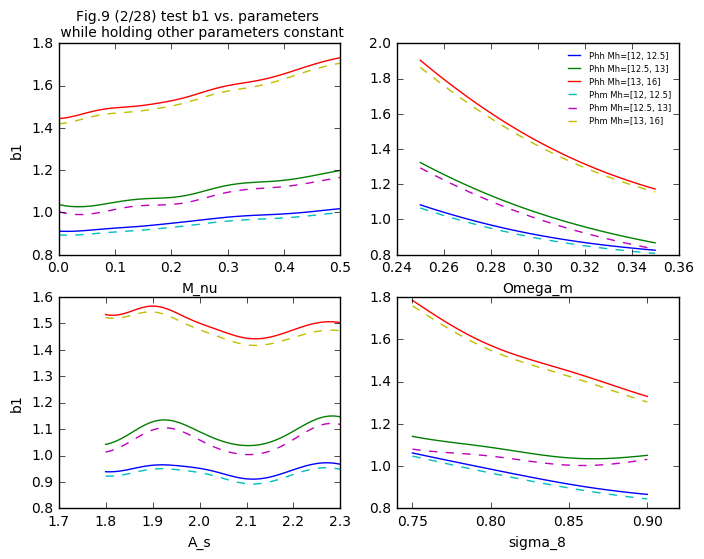

In [166]:
f,((ax1, ax2), (ax3, ax4)) = subplots(2,2, figsize=(8,6))


mnv_arr = linspace(0,0.5,100)
om_arr = linspace(0.25, 0.35, 100)
As_arr = linspace(1.8, 2.3, 100)
si8_arr = linspace(0.75, 0.9, 100)

jj =0
for iobs in (idata[:, -6:-3], idata[:, -3:]):
    lss = ['-','--'][jj]
    emulator = WLanalysis.buildInterpolator(obs_arr=iobs, cosmo_params=idata[:, :3])
    emulator_si8 = WLanalysis.buildInterpolator(obs_arr=iobs, cosmo_params=idata[:, [0,1,3]])

    b1_mnv = array([emulator( (imnv,0.3,2.1)) for imnv in mnv_arr])
    b1_om = array([emulator( (0.0,iom,2.1)) for iom in om_arr])
    b1_As = array([emulator( (0.0,0.3,iAs)) for iAs in As_arr])
    b1_si8 = array([emulator_si8( (0.0,0.3,isi8)) for isi8 in si8_arr])

    b1labels =['Mh=[12, 12.5]', 'Mh=[12.5, 13]', 'Mh=[13, 16]']
    for i in range(3):
        ax1.plot(mnv_arr, b1_mnv.T[i],lss)
        ax2.plot(om_arr, b1_om.T[i],lss,label=['Phh ','Phm '][jj]+b1labels[i])
        ax3.plot(As_arr, b1_As.T[i],lss)
        ax4.plot(si8_arr, b1_si8.T[i],lss)
    jj+=1
ax2.legend(loc=1,frameon=0,fontsize=6)
ax1.set_ylabel('b1')
ax3.set_ylabel('b1')
ax1.set_title('Fig.9 (2/28) test b1 vs. parameters \n while holding other parameters constant',fontsize=10)
ax1.set_xlabel('M_nu')
ax2.set_xlabel('Omega_m')
ax3.set_xlabel('A_s')
ax4.set_xlabel('sigma_8')
show()

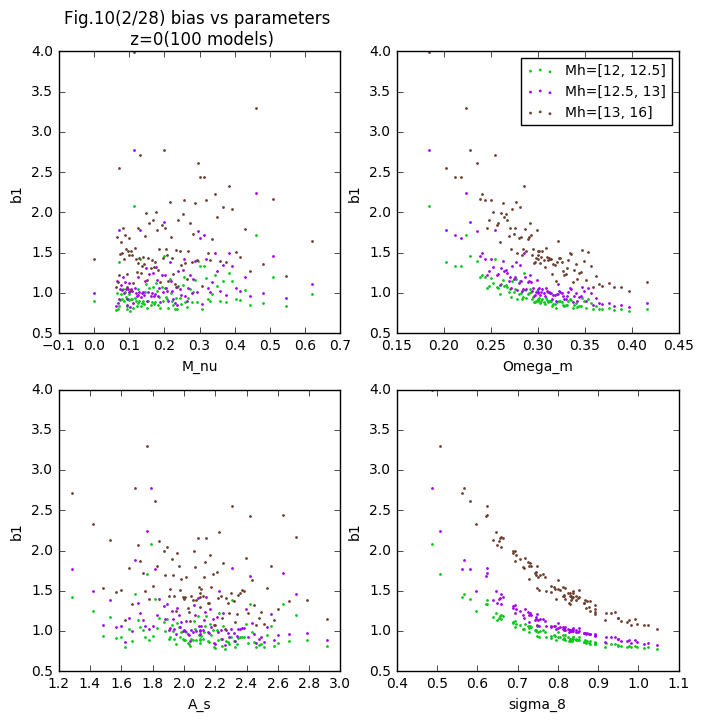

In [170]:
#idata = loadtxt('cosmological_parameters_b1.txt')[:-1] #mnv, om, As, si8, b1a, b1b, b1c
mnv, om, As, si8, b1aPhh, b1bPhh, b1cPhh, b1a, b1b, b1c = idata.T
f,((ax1, ax2), (ax3, ax4)) = subplots(2,2, figsize=(8,8))
iss = 1
seed(34)
iii=0
for b1 in [b1a, b1b, b1c]:
    icolor=rand(3)
    ax1.scatter(mnv, b1, edgecolors=icolor,c=icolor,s=iss)
    ax2.scatter(om, b1, edgecolors=icolor,c=icolor,s=iss,label=b1labels[iii])
    ax3.scatter(As, b1, edgecolors=icolor,c=icolor,s=iss)
    ax4.scatter(si8, b1, edgecolors=icolor,c=icolor,s=iss)
    iii+=1
ax2.legend(frameon=1,loc=0,fontsize=10)
ax1.set_title('Fig.10(2/28) bias vs parameters \n z=0(100 models)')
jjj=0
paramlabels=['M_nu', 'Omega_m', 'A_s', 'sigma_8']
for iax in [ax1,ax2,ax3,ax4]:
    iax.set_ylim(0.5,4)
    iax.set_xlabel(paramlabels[jjj])
    iax.set_ylabel('b1')
    jjj+=1
show()

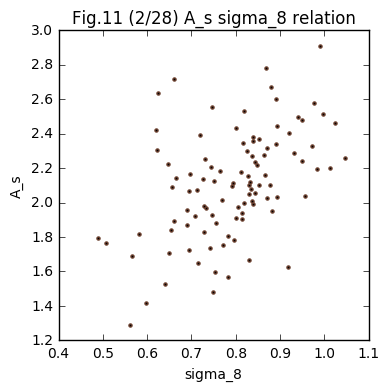

In [171]:
figure(figsize=(4,4))
scatter(si8, As, edgecolors=icolor,c='k',s=5)
xlabel('sigma_8')
ylabel('A_s')
title('Fig.11 (2/28) A_s sigma_8 relation')
show()